In [1]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs --break-system-packages
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO --break-system-packages

In [2]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO

In [3]:
# !pip install -e ../../objFuncs
# !pip install -e ../../pyBO

In [4]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
import pandas as pd

In [5]:
import objFuncs
from objFuncs import VM
from objFuncs import residuals
from objFuncs.util import plot_obj_history, plot_multi_obj_history
from objFuncs import flame_utils_kilean as flame_utils

objFuncs version: 1.1.0. updated on 2023-12-04


In [6]:
decision_CSETs=[
    'FS2_BTS:PSC2_D3930:I_CSET',
    'FS2_BTS:PSC2_D3945:I_CSET',
]
objective_goal = { 
    'FS2_BTS:BPM_D3958:XPOS_RD' : 0.0,
    'FS2_BTS:BPM_D4006:XPOS_RD' : 0.0,
}
objective_norm = {pv:1.0 for pv in objective_goal.keys()}
objective_weight = {pv:1.0 for pv in objective_goal.keys()}
objective_RDs = list(objective_goal.keys())

n_condition = 3
conditional_SETs = {
    'FS2_BTS:PSQ_D3950:I_CSET':[80,100, 80],
    'FS2_BTS:PSQ_D3955:I_CSET':[80, 80,100],
}

In [7]:
fm_vms = []
for i in range(n_condition):
    fm_vms.append( 
        flame_utils.VM(
            latfile = "test_FS2a_20231130_040841_read.lat",
            decision_CSETs = decision_CSETs,
            objective_RDs  = objective_RDs,
            conditional_SETs = {key:val[i] for key, val in conditional_SETs.items()},
        )
    )

'test_FS2a_20231130_040841_read.lat' does not exist in current working path.
FLAME lattice file found from lat repo: 
    /home/devuser/Desktop/WinHome/GitHub/objFuncs/objFuncs/FLAME_lat/test_FS2a_20231130_040841_read.lat
'test_FS2a_20231130_040841_read.lat' does not exist in current working path.
FLAME lattice file found from lat repo: 
    /home/devuser/Desktop/WinHome/GitHub/objFuncs/objFuncs/FLAME_lat/test_FS2a_20231130_040841_read.lat
'test_FS2a_20231130_040841_read.lat' does not exist in current working path.
FLAME lattice file found from lat repo: 
    /home/devuser/Desktop/WinHome/GitHub/objFuncs/objFuncs/FLAME_lat/test_FS2a_20231130_040841_read.lat


In [8]:
machineIO_vms = []
for fm_vm in fm_vms:
    machineIO_vms.append(
        VM(
            x0 = fm_vm.x0,
            fun = fm_vm,
            decision_CSETs = decision_CSETs,
            objective_RDs = objective_RDs,
            fetch_data_time_span = 0.2,
        )
    )

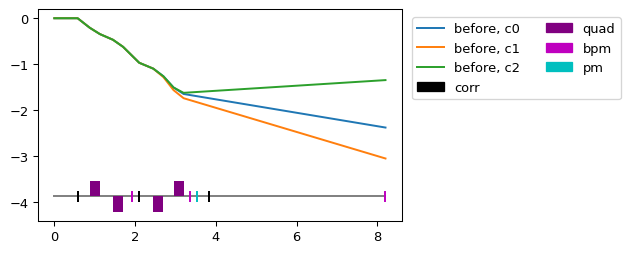

In [9]:
r0 = []
for fm_vm in fm_vms:
    r,s = fm_vm.fm.run(monitor='all',to_element=fm_vm.last_elem_index)
    r0.append( fm_vm.fm.collect_data(r,'pos','xcen','ycen') )

fig,ax = plt.subplots(figsize=(5,3),dpi=94)
for i,r0_ in enumerate(r0):
    ax.plot(r0_['pos'],r0_['xcen'],label='before, c'+str(i))
fm_vm.fm.plot_lattice(end=fm_vm.last_elem_index+1,ax=ax,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1])

In [10]:
objFuncs._global_machineIO.fetch_data = machineIO_vms[0].fetch_data
objFuncs._global_machineIO.ensure_set = machineIO_vms[0].ensure_set
objFuncs._global_machineIO._test = True

In [11]:
fm_vm.x0

[-15.990100000000002, 11.56861]

In [12]:
res = residuals.residualObjMultiConditionalVar(  
    decision_CSETs = decision_CSETs,
    decision_min= -20,
    decision_max=  20,
    objective_goal = objective_goal,
    objective_norm = objective_norm,
    objective_weight = objective_weight,
    conditional_SETs = conditional_SETs,
    var_obj_weight_fraction = 0.9,
    )

for i in range(n_condition):
    res.residualObj[i].machineIO = machineIO_vms[i]

[condition_controller] ======== class info ========
init_time: 2023-12-15 10:40:15.713606
class_hierarchy: [
    objFuncBase]
decision_CSETs: [
    FS2_BTS:PSQ_D3950:I_CSET, FS2_BTS:PSQ_D3955:I_CSET]
decision_min: [80. 80.]
decision_max: [100. 100.]
decision_bounds: [[ 80 100]
 [ 80 100]]
decision_RDs: [
    FS2_BTS:PSQ_D3950:I_RD, FS2_BTS:PSQ_D3955:I_RD]
decision_tols: None
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: condition_controler
logging_fname: None
x0: [
    0.5, 0.5]

[condition 0] ======== class info ========
init_time: 2023-12-15 10:40:15.764883
class_hierarchy: [
    residualObj, objFuncBase]
decision_CSETs: [
    FS2_BTS:PSC2_D3930:I_CSET, FS2_BTS:PSC2_D3945:I_CSET]
decision_min: [-20. -20.]
decision_max: [20. 20.]
decision_bounds: [[-20.  20.]
 [-20.  20.]]
decision_RDs: [
    FS2_BTS:PSC2_D3930:I_RD, FS2_BTS:PSC2_D3945:I_RD]
decision_tols: None
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_ta

In [13]:
res.history['condition0']['objective_RDs']

{'names': ['FS2_BTS:BPM_D3958:XPOS_RD', 'FS2_BTS:BPM_D4006:XPOS_RD'],
 'values': []}

In [14]:
plot_decision = plot_obj_history(
    res.history['decision_CSETs'],
    title='decision_CSETs',
)
plot_conditions_RDs = plot_multi_obj_history(
    histories = [res.history['condition'+str(i)]['objective_RDs'] for i in range(n_condition)],
    history_labels = ['C'+str(i) for i in range(n_condition)],
    title='multi-condition_obj_RDs',
)
plot_objectives_var = plot_obj_history(
    res.history['objectives_var'],
    title='objectives_var',
)
callbacks = [plot_decision,plot_conditions_RDs,plot_objectives_var]
# callbacks = []

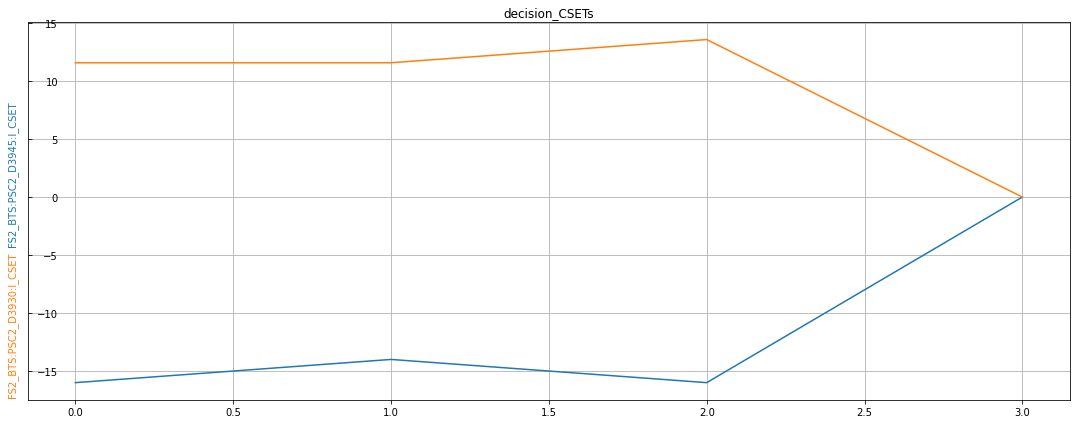

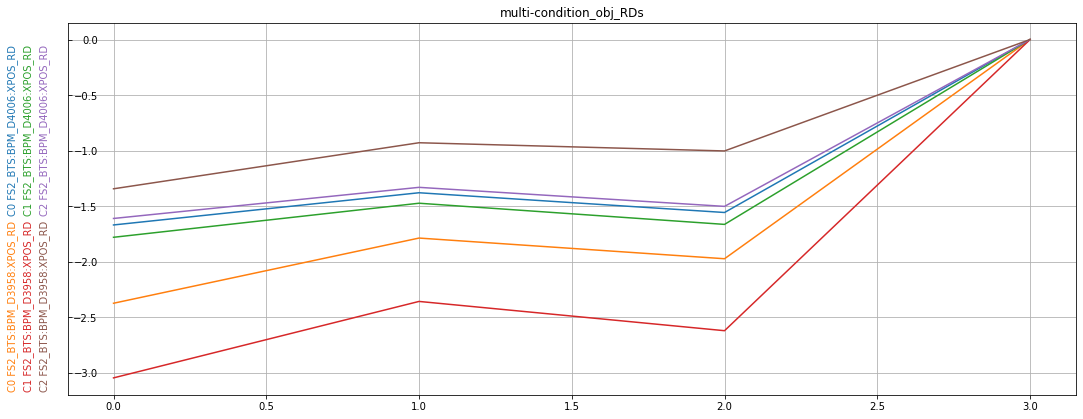

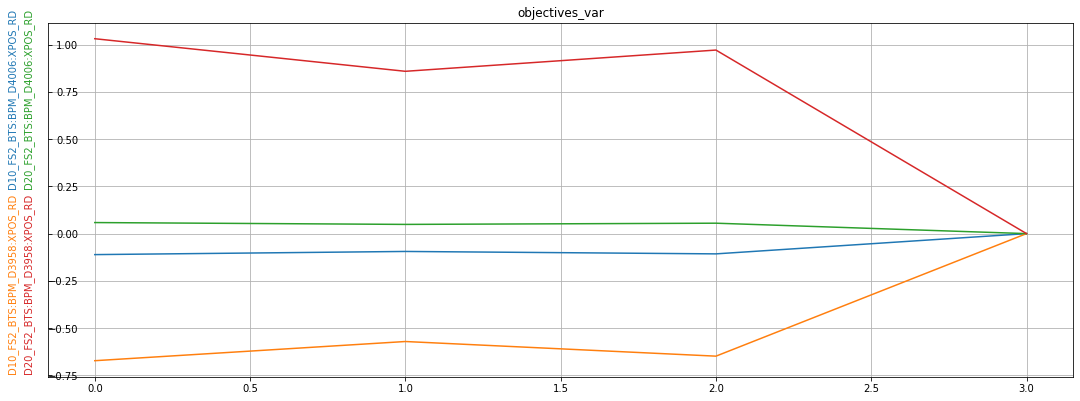

In [15]:
result = res.lsq_linear(jac_use3points=False,callbacks=callbacks)
for f in callbacks:
    f.close()

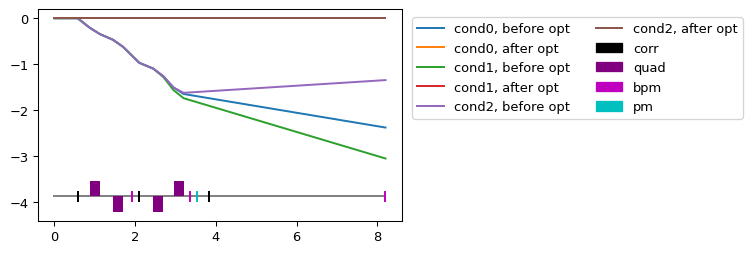

In [16]:
r1 = []
for fm_vm in fm_vms:
    r,s = fm_vm.fm.run(monitor='all',to_element=fm_vm.last_elem_index)
    r1.append( fm_vm.fm.collect_data(r,'pos','xcen','ycen') )

fig,ax = plt.subplots(figsize=(5,3),dpi=94)
i=0
for r0_, r1_ in zip(r0,r1):
    ax.plot(r0_['pos'],r0_['xcen'],label='cond'+str(i)+', before opt')
    ax.plot(r1_['pos'],r1_['xcen'],label='cond'+str(i)+', after opt')
    i+=1
fm_vm.fm.plot_lattice(end=fm_vm.last_elem_index+1,ax=ax,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1])

In [17]:
for name, val in zip(res.history['jacobian_var']['names'], res.history['jacobian_var']['values'][0]):
    print( name, val )

d (D10 FS2_BTS:BPM_D3958:XPOS_RD)/d FS2_BTS:PSC2_D3930:I_CSET 0.007528445959187835
d (D10 FS2_BTS:BPM_D3958:XPOS_RD)/d FS2_BTS:PSC2_D3945:I_CSET 0.0017643376780854605
d (D10 FS2_BTS:BPM_D4006:XPOS_RD)/d FS2_BTS:PSC2_D3930:I_CSET 0.045671118977257286
d (D10 FS2_BTS:BPM_D4006:XPOS_RD)/d FS2_BTS:PSC2_D3945:I_CSET 0.010824513142447312
d (D20 FS2_BTS:BPM_D3958:XPOS_RD)/d FS2_BTS:PSC2_D3930:I_CSET -0.0043889004946154435
d (D20 FS2_BTS:BPM_D3958:XPOS_RD)/d FS2_BTS:PSC2_D3945:I_CSET -0.0015172550678143153
d (D20 FS2_BTS:BPM_D4006:XPOS_RD)/d FS2_BTS:PSC2_D3930:I_CSET -0.0775779083889867
d (D20 FS2_BTS:BPM_D4006:XPOS_RD)/d FS2_BTS:PSC2_D3945:I_CSET -0.027018870389976746
